必要ライブラリのインストール

In [1]:
!pip install dfply


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install shap


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
import pandas as pd
import numpy as np
from sklearn import svm
import scipy.stats
import matplotlib.pyplot as plt
import csv
import re
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import preprocessing
import datetime
from dfply import *
import random
import gc
import shap
plt.style.use('ggplot')
# pd.options.display.float_format = '{:.2f}'.format

c:\Users\小山佳祐\Desktop\研究元ファイル\abnormal\research_abnormal\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


データの読み込みを行う

ここではデータの読み込みと同時に新しいカラム、id、measurement_ymd（日付部分）、measurement_ymd_h（時間部分）measurement_ymd_hms(完全な日付と時間、分、秒)を作成する。

measurement_dataは観測した日時まで記録されているがこれを丸め込んで新たな日時データを作成している。

In [4]:
raw_data_ECDIS = pd.read_csv('../data/ECDIS__FMD-3x00.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})

raw_data_ECDIS = raw_data_ECDIS >> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\2712817729.py:1: DtypeWarning: Columns (11,12,13,14,15,16,22,26,27,28,29,31,32,33,39,43,44,45,51,55,58,91,92,93,94,95,97,99,100,102,103,104,105,106,107,108,109,110,111,113,115,116,118,119,120,121,122,123,124,125,126,127,129,131,132,134,135,136,137,138) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_ECDIS = pd.read_csv('../data/ECDIS__FMD-3x00.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})


In [5]:
print(raw_data_ECDIS["measurement_date"])

0          2020-06-03 07:54:06
1          2020-06-03 08:00:01
2          2020-06-03 09:00:02
3          2020-06-04 01:00:01
4          2020-06-04 02:00:01
                  ...         
2057533    2021-04-20 19:00:02
2057534    2021-04-20 20:00:01
2057535    2021-04-20 21:00:01
2057536    2021-04-20 22:00:02
2057537    2021-04-20 23:00:02
Name: measurement_date, Length: 2057538, dtype: object


ここではRadarのデータを読み込む。同様に新しくカラムを作成する。

In [6]:
raw_data_Radar= pd.read_csv('../data/Radar__FAR-3xx0.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})
raw_data_Radar = raw_data_Radar>> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\642471685.py:1: DtypeWarning: Columns (57,58,59,60,61,62,63,64,65,66,70,71,72,73,74,75,76,77,78,79,99,101,105,171,173,174,175,176,179,180,198,199,202,204,244,245,246,247,249,250,251,255,256,257,258,259,260,264,265,266,267,268,269) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data_Radar= pd.read_csv('../data/Radar__FAR-3xx0.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})


作成したデータの確認

In [7]:
raw_data_ECDIS.head(5)

,equipment_label_no,f_shipno,imono,shipnameen,monitored_equipment_category_name,monitored_equipment_model_name,measurement_date,service_gateway_date,system_date_time,list_version,...,rcu3_units_status_main__timer_int_sta,rcu3_units__unit,rcu3_units__unit_name,rcu3_units__unit_type,created_at,is_hermace_data,id,measurement_ymd,measurement_ymd_h,measurement_ymd_hms
0,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 07:54:06,2020-06-03 07:54:06,2020-06-03 07:56:40,1,...,NaN,NaN,NaN,NaN,2020-06-03 08:01:24,f,9883118-4533,2020-06-03,07,2020-06-03 07:00:00
1,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 08:00:01,2020-06-03 08:00:01,2020-06-03 08:02:36,1,...,NaN,NaN,NaN,NaN,2020-06-03 08:11:22,f,9883118-4533,2020-06-03,08,2020-06-03 08:00:00
2,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 09:00:02,2020-06-03 09:00:02,2020-06-03 09:02:36,1,...,NaN,NaN,NaN,NaN,2020-06-03 09:08:51,f,9883118-4533,2020-06-03,09,2020-06-03 09:00:00
3,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-04 01:00:01,2020-06-04 01:00:01,2020-06-04 01:02:37,1,...,NaN,NaN,NaN,NaN,2020-06-04 15:39:03,f,9883118-4533,2020-06-04,01,2020-06-04 01:00:00
4,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-04 02:00:01,2020-06-04 02:00:01,2020-06-04 02:02:37,1,...,NaN,NaN,NaN,NaN,2020-06-04 02:08:51,f,9883118-4533,2020-06-04,02,2020-06-04 02:00:00


In [8]:
raw_data_Radar.head(5)

,equipment_label_no,f_shipno,imono,shipnameen,monitored_equipment_category_name,monitored_equipment_model_name,measurement_date,service_gateway_date,is_xml_data_format,processor_unit_units_status_boot_device_model_name,...,rsb_units_parent_name,rsb_units_status_main_mtr_dipsw,rsb_units_status_main_pm_dipsw,rsb_units_status_main_rfc_dipsw,created_at,is_hermace_data,id,measurement_ymd,measurement_ymd_h,measurement_ymd_hms
0,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 07:00:02,2020-12-23 07:00:02,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 07:05:20,f,9863558-7073,2020-12-23,07,2020-12-23 07:00:00
1,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 08:00:01,2020-12-23 08:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 08:05:36,f,9863558-7073,2020-12-23,08,2020-12-23 08:00:00
2,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 09:00:01,2020-12-23 09:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 09:05:36,f,9863558-7073,2020-12-23,09,2020-12-23 09:00:00
3,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-25 04:00:02,2020-12-25 04:00:02,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-25 04:08:14,f,9863558-7073,2020-12-25,04,2020-12-25 04:00:00
4,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-25 05:00:01,2020-12-25 05:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-25 05:08:10,f,9863558-7073,2020-12-25,05,2020-12-25 05:00:00


データから必要なカラムを抜き出す

In [9]:
raw_data_ECDIS_select = raw_data_ECDIS[["id","equipment_label_no","f_shipno","measurement_date"
                                        ,"processor_unit_units_hardware_info__serial_number_cpu_bd","monitor1_units__unit","monitor2_units__unit"
                                        ,"measurement_ymd","measurement_ymd_h","measurement_ymd_hms"
                                        ,"monitor1_units_status_main__temp","monitor1_units_status_main__fan1"
                                        ,"monitor1_units_status_main__fan2","monitor1_units_status_main__fan3"
                                        ,"monitor2_units_status_main__temp","monitor2_units_status_main__fan1"
                                        ,"monitor2_units_status_main__fan2","monitor2_units_status_main__fan3","processor_unit_units_status_cpu_board__cpu_fan"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_temp","processor_unit_units_status_cpu_board__cpu_core_temp"
                                        ,"processor_unit_units_status_cpu_board__gpu_core_temp","processor_unit_units_status_cpu_board__remote1_temp"
                                        ,"processor_unit_units_status_cpu_board__remote2_temp","processor_unit_units_status_cpu_board__cpu_core_vol"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_vbat","processor_unit_units_status_cpu_board__cpu_bd_p3_3v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_p5v","processor_unit_units_status_cpu_board__cpu_bd_p12v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_fan1","processor_unit_units_status_cpu_board__cpu_bd_fan2"
                                        ,"processor_unit_units_status_boot_device__wearout_ind"]]

raw_data_ECDIS_select.head(5)

,id,equipment_label_no,f_shipno,measurement_date,processor_unit_units_hardware_info__serial_number_cpu_bd,monitor1_units__unit,monitor2_units__unit,measurement_ymd,measurement_ymd_h,measurement_ymd_hms,...,processor_unit_units_status_cpu_board__remote1_temp,processor_unit_units_status_cpu_board__remote2_temp,processor_unit_units_status_cpu_board__cpu_core_vol,processor_unit_units_status_cpu_board__cpu_bd_vbat,processor_unit_units_status_cpu_board__cpu_bd_p3_3v,processor_unit_units_status_cpu_board__cpu_bd_p5v,processor_unit_units_status_cpu_board__cpu_bd_p12v,processor_unit_units_status_cpu_board__cpu_bd_fan1,processor_unit_units_status_cpu_board__cpu_bd_fan2,processor_unit_units_status_boot_device__wearout_ind
0,9883118-4533,4533,9883118,2020-06-03 07:54:06,O19H6555,MU-270W,NaN,2020-06-03,07,2020-06-03 07:00:00,...,43.0,43.0,0.844,3.698,3.317,5.104,12.063,4663.0,4627.0,1.0
1,9883118-4533,4533,9883118,2020-06-03 08:00:01,O19H6555,MU-270W,NaN,2020-06-03,08,2020-06-03 08:00:00,...,43.0,43.0,0.844,3.698,3.317,5.104,12.063,4659.0,4623.0,1.0
2,9883118-4533,4533,9883118,2020-06-03 09:00:02,O19H6555,MU-270W,NaN,2020-06-03,09,2020-06-03 09:00:00,...,44.0,44.0,0.844,3.698,3.317,5.104,12.063,4639.0,4639.0,1.0
3,9883118-4533,4533,9883118,2020-06-04 01:00:01,O19H6555,MU-270W,NaN,2020-06-04,01,2020-06-04 01:00:00,...,41.0,41.0,0.855,3.698,3.317,5.104,12.063,4667.0,4615.0,1.0
4,9883118-4533,4533,9883118,2020-06-04 02:00:01,O19H6555,MU-270W,NaN,2020-06-04,02,2020-06-04 02:00:00,...,45.0,45.0,0.844,3.698,3.317,5.104,12.063,4639.0,4659.0,1.0


名前の変更。

In [10]:
data_ECDIS=raw_data_ECDIS_select.rename(columns={"processor_unit_units_hardware_info__serial_number_cpu_bd":"processor_unit_units_hardware_info_serial_number_cpu_bd"
                                                 ,"monitor1_units__unit":"monitor1_units_unit"
                                                 ,"monitor2_units__unit":"monitor2_units_unit"
                                                 ,"monitor1_units_status_main__temp":"monitor1_units_status_main_temp"
                                                 ,"monitor1_units_status_main__fan1":"monitor1_units_status_main_fan1"
                                                 ,"monitor1_units_status_main__fan2":"monitor1_units_status_main_fan2"
                                                 ,"monitor1_units_status_main__fan3":"monitor1_units_status_main_fan3"
                                                 ,"monitor2_units_status_main__temp":"monitor2_units_status_main_temp"
                                                 ,"monitor2_units_status_main__fan1":"monitor2_units_status_main_fan1"
                                                 ,"monitor2_units_status_main__fan2":"monitor2_units_status_main_fan2"
                                                 ,"monitor2_units_status_main__fan3":"monitor2_units_status_main_fan3"
                                                 ,"processor_unit_units_status_cpu_board__cpu_fan":"processor_unit_units_status_cpu_board_cpu_fan"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_temp":"processor_unit_units_status_cpu_board_cpu_bd_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_temp":"processor_unit_units_status_cpu_board_cpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__gpu_core_temp":"processor_unit_units_status_cpu_board_gpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote1_temp":"processor_unit_units_status_cpu_board_remote1_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote2_temp":"processor_unit_units_status_cpu_board_remote2_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_vol":"processor_unit_units_status_cpu_board_cpu_core_vol"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_vbat":"processor_unit_units_status_cpu_board_cpu_bd_vbat"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p3_3v":"processor_unit_units_status_cpu_board_cpu_bd_p3_3v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p5v":"processor_unit_units_status_cpu_board_cpu_bd_p5v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p12v":"processor_unit_units_status_cpu_board_cpu_bd_p12v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan1":"processor_unit_units_status_cpu_board_cpu_bd_fan1"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan2":"processor_unit_units_status_cpu_board_cpu_bd_fan2"
                                                 ,"processor_unit_units_status_boot_device__wearout_ind":"processor_unit_units_status_boot_device_wearout_ind"
                                                })

In [11]:
data_Radar = raw_data_Radar[["id","equipment_label_no","f_shipno","measurement_date",
                             "processor_unit_units_hardware_info_serial_number_cpu_bd","monitor1_units_unit","monitor2_units_unit",
                             "measurement_ymd","measurement_ymd_h","measurement_ymd_hms",
                             "monitor1_units_status_main_temp","monitor1_units_status_main_fan1",
                            "monitor1_units_status_main_fan2","monitor1_units_status_main_fan3"
                             ,"monitor2_units_status_main_temp"
                             ,"monitor2_units_status_main_fan1","monitor2_units_status_main_fan2"
                             ,"monitor2_units_status_main_fan3","processor_unit_units_status_cpu_board_cpu_fan",
                            "processor_unit_units_status_cpu_board_cpu_bd_temp","processor_unit_units_status_cpu_board_cpu_core_temp",
                            "processor_unit_units_status_cpu_board_gpu_core_temp","processor_unit_units_status_cpu_board_remote1_temp",
                            "processor_unit_units_status_cpu_board_remote2_temp","processor_unit_units_status_cpu_board_cpu_core_vol",
                            "processor_unit_units_status_cpu_board_cpu_bd_vbat","processor_unit_units_status_cpu_board_cpu_bd_p3_3v",
                            "processor_unit_units_status_cpu_board_cpu_bd_p5v","processor_unit_units_status_cpu_board_cpu_bd_p12v",
                            "processor_unit_units_status_cpu_board_cpu_bd_fan1","processor_unit_units_status_cpu_board_cpu_bd_fan2",
                            "processor_unit_units_status_storage_device_wearout_ind"]]

データの結合を行う

In [12]:
con=pd.concat([data_Radar, data_ECDIS])
data_con=con

キャッシュの削除

In [13]:
del raw_data_ECDIS
del raw_data_Radar

In [14]:
gc.collect()

0

データの確認

In [15]:
print("ECDIS&Radar")
print("f_shipnoユニーク数          :",data_con["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_con["equipment_label_no"].unique()),"\n")

print("ECDIS")
print("f_shipnoユニーク数          :",data_ECDIS["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_ECDIS["equipment_label_no"].unique()),"\n")

print("Radar")
print("f_shipnoユニーク数          :",data_Radar["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_Radar["equipment_label_no"].unique()),"\n")

ECDIS&Radar
f_shipnoユニーク数          : 114
equipment_label_noユニーク数: 367 

ECDIS
f_shipnoユニーク数          : 112
equipment_label_noユニーク数: 271 

Radar
f_shipnoユニーク数          : 46
equipment_label_noユニーク数: 96 



In [16]:
# raw_data.shape
print("行数: "+str(data_con.shape[0]))
print("列数: "+str(data_con.shape[1]))
#データ期間
print("データ開始日時: "+str(data_con["measurement_date"].min()))
print("データ終了日時: "+str(data_con["measurement_date"].max()))
print("f_shipno(ユニーク数): "+str(data_con["f_shipno"].nunique()))
print("equipment_label_no(ユニーク数): "+str(data_con["equipment_label_no"].nunique()))

行数: 2339341
列数: 33
データ開始日時: 2014-10-10 09:00:01
データ終了日時: 2021-04-20 23:34:16
f_shipno(ユニーク数): 114
equipment_label_no(ユニーク数): 367


フォーマットの変更

In [17]:
data_con["measurement_ymd_hms"] = pd.to_datetime(data_con["measurement_ymd_hms"], format='%Y-%m-%d %H:%M:%S')
data_con.describe()

,measurement_ymd_hms,monitor1_units_status_main_temp,monitor1_units_status_main_fan1,monitor1_units_status_main_fan2,monitor1_units_status_main_fan3,monitor2_units_status_main_temp,monitor2_units_status_main_fan1,monitor2_units_status_main_fan2,monitor2_units_status_main_fan3,processor_unit_units_status_cpu_board_cpu_fan,...,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_boot_device_wearout_ind
count,2339341,2.316819e+06,2.130016e+06,2.074404e+06,2.074404e+06,60167.000000,28627.000000,15343.000000,15343.000000,2.339011e+06,...,2.339012e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,1.332672e+06
mean,2020-02-29 14:19:01.995460352,4.169940e+01,3.690696e+03,3.484889e+03,3.397851e+03,40.137035,4139.440004,2977.105195,2920.743727,5.911445e+03,...,4.151572e+01,4.015968e+01,8.891960e-01,3.718789e+00,3.364658e+00,5.110331e+00,1.208127e+01,4.654892e+03,4.775220e+03,1.064522e+00
min,2014-10-10 09:00:00,-2.100000e+01,0.000000e+00,2.742000e+03,2.657000e+03,-20.000000,2868.000000,2839.000000,2809.000000,-1.000000e+00,...,1.300000e+01,1.300000e+01,7.730000e-01,3.672000e+00,3.300000e+00,5.000000e+00,1.131300e+01,-1.000000e+00,3.573000e+03,1.000000e+00
25%,2019-09-19 21:00:00,3.800000e+01,2.985000e+03,2.985000e+03,2.868000e+03,38.000000,3043.000000,2956.000000,2868.000000,5.825000e+03,...,3.900000e+01,3.800000e+01,8.440000e-01,3.724000e+00,3.352000e+00,5.078000e+00,1.206300e+01,4.587000e+03,4.716000e+03,1.000000e+00
50%,2020-07-26 08:00:00,4.200000e+01,3.073000e+03,3.073000e+03,2.956000e+03,40.000000,3102.000000,2985.000000,2956.000000,5.914000e+03,...,4.100000e+01,4.000000e+01,8.670000e-01,3.724000e+00,3.352000e+00,5.104000e+00,1.206300e+01,4.655000e+03,4.770000e+03,1.000000e+00
75%,2020-12-22 11:00:00,4.500000e+01,5.209000e+03,4.595000e+03,4.595000e+03,43.000000,5424.000000,2985.000000,2956.000000,5.986000e+03,...,4.400000e+01,4.200000e+01,9.020000e-01,3.724000e+00,3.381000e+00,5.130000e+00,1.212500e+01,4.724000e+03,4.847000e+03,1.000000e+00
max,2021-04-20 23:00:00,7.200000e+01,5.542000e+03,4.811000e+03,4.841000e+03,54.000000,5555.000000,3051.000000,3014.000000,6.323000e+03,...,6.400000e+01,6.300000e+01,1.157000e+00,3.750000e+00,3.455000e+00,5.208000e+00,1.225000e+01,4.958000e+03,5.113000e+03,2.000000e+00
std,NaN,4.601056e+00,1.041321e+03,7.338120e+02,7.798650e+02,4.088452,1207.438474,24.402830,56.522768,1.187962e+02,...,3.682773e+00,3.702736e+00,7.324197e-02,1.126195e-02,2.998924e-02,3.411286e-02,5.274771e-02,9.533125e+01,9.885745e+01,2.456810e-01


ここでデータのカラム値は以下の通りである。
カラム名	説明

id	                                                船舶番号 (f_shipno) と装置ラベル番号 (equipment_label_no) を結合したもの（ユニークID）

equipment_label_no	                                装置ラベル番号

f_shipno	                                        船舶番号

measurement_date	                                測定日時

processor_unit_units_hardware_info_serial_number_cpu_bd	CPUボードのシリアル番号

monitor1_units_unit	                                モニター1のユニット情報

monitor2_units_unit	                                モニター2のユニット情報

measurement_ymd	                                    測定日の年月日部分（YYYY-MM-DD）

measurement_ymd_h	                                測定日の時間部分（HH）

measurement_ymd_hms	                                測定日の詳細な日時（YYYY-MM-DD HH:00:00）

monitor1_units_status_main_temp	                    モニター1のメインステータスの温度

monitor1_units_status_main_fan1	                    モニター1のメインステータスのファン1

monitor1_units_status_main_fan2	                    モニター1のメインステータスのファン2

monitor1_units_status_main_fan3	                    モニター1のメインステータスのファン3

monitor2_units_status_main_temp	                    モニター2のメインステータスの温度

monitor2_units_status_main_fan1	                    モニター2のメインステータスのファン1

monitor2_units_status_main_fan2	                    モニター2のメインステータスのファン2

monitor2_units_status_main_fan3	                    モニター2のメインステータスのファン3

processor_unit_units_status_cpu_board_cpu_fan	    CPUボードのCPUファンステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度

processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_remote1_temp	リモート1の温度

processor_unit_units_status_cpu_board_remote2_temp	リモート2の温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2

processor_unit_units_status_boot_device_wearout_ind	起動デバイスの摩耗インデックス

以下、データの加工を行う。なお取り出す条件は

・一時間に複数のデータを取得した場合は最初に取得したデータのみを使用する

・そのうえで一日に取得したデータの合計が15件に満たない場合はその日のデータは使用しない

最初に取得したデータのみを使用する

ロジックはid、日、時間でグループ分けを行って最も時間が上のものを取り出す。

In [18]:
# 1時間に1データに変更
data_con["measurement_date"] = pd.to_datetime(data_con["measurement_date"], format='%Y-%m-%d %H:%M:%S')

data_con["order"] = data_con.groupby(["id", "measurement_ymd", "measurement_ymd_h"])["measurement_date"].rank()

modified_data = data_con[data_con["order"]==1]

取得したデータが15件に満たない場合はその日のデータは使用しない

ロジックは、idｔ日にちでグループ分けしてそのユニーク値を数ええる。さらにその中で最も若い日付と古い日付を算出する。

In [19]:
check_day_cnt = modified_data.groupby(["id", "measurement_ymd"]).agg({"measurement_date":"nunique"}).assign(
    min_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"min"}),
    max_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"max"})).reset_index()

check_day_cnt["id_date"] = check_day_cnt["id"]+"-"+check_day_cnt["measurement_ymd"]

check_day_cnt = check_day_cnt.rename(columns={"measurement_date":"cnt"})

check_day_cnt.head(5)

,id,measurement_ymd,cnt,min_measurement_date,max_measurement_date,id_date
0,9531868-309,2014-10-10,15,2014-10-10 09:00:01,2014-10-10 23:00:01,9531868-309-2014-10-10
1,9531868-309,2014-10-11,24,2014-10-11 00:00:02,2014-10-11 23:00:01,9531868-309-2014-10-11
2,9531868-309,2014-10-12,24,2014-10-12 00:00:01,2014-10-12 23:00:01,9531868-309-2014-10-12
3,9531868-309,2014-10-13,24,2014-10-13 00:00:01,2014-10-13 23:00:02,9531868-309-2014-10-13
4,9531868-309,2014-10-14,24,2014-10-14 00:00:02,2014-10-14 23:00:02,9531868-309-2014-10-14


さらに作成したcntの中で15件以上のものを抜き出す。

In [39]:
target_id_date = check_day_cnt[check_day_cnt["cnt"] >= 15]["id_date"]

条件１を施したデータに対して準備を行う

In [21]:
modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]
# modified_data.head()

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1843079938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]


条件１のデータのうち条件２にも当てはまるものを抜き出す

In [22]:
final_data = modified_data[modified_data["tag"].isin(target_id_date)]
final_data.shape

(2275886, 35)

以下、サブカテゴリ分けを行う。なお今回はcpuのシリアルボードナンバーでカテゴリ分けされている。

In [23]:
(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]).unique()

array(['19', '17', '18', '16', '20', '13', '15', '14'], dtype=object)

ADP555の抜き出し

In [24]:
data_ADP556 = final_data[(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]
                          .isin(['20','19','18','17']))]
data_ADP556[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"
             ,]].describe()

,processor_unit_units_status_cpu_board_cpu_fan,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_cpu_board_cpu_bd_temp,processor_unit_units_status_cpu_board_cpu_core_temp,processor_unit_units_status_cpu_board_gpu_core_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp
count,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06
mean,5.913182e+03,4.680439e+03,4.801826e+03,4.235380e+01,6.002206e+01,6.044465e+01,8.568314e-01,3.721660e+00,3.351180e+00,5.102109e+00,1.209864e+01,4.133065e+01,4.048215e+01
std,1.214072e+02,9.150471e+01,9.149267e+01,3.711986e+00,4.535062e+00,4.477263e+00,2.779877e-02,8.103240e-03,1.765666e-02,3.078057e-02,3.545566e-02,3.658319e+00,3.666114e+00
min,-1.000000e+00,-1.000000e+00,3.573000e+03,1.600000e+01,2.700000e+01,0.000000e+00,7.730000e-01,3.672000e+00,3.300000e+00,5.000000e+00,1.131300e+01,1.600000e+01,1.500000e+01
25%,5.818000e+03,4.619000e+03,4.741000e+03,4.000000e+01,5.700000e+01,5.800000e+01,8.320000e-01,3.724000e+00,3.334000e+00,5.078000e+00,1.206300e+01,3.900000e+01,3.800000e+01
50%,5.914000e+03,4.687000e+03,4.808000e+03,4.200000e+01,6.000000e+01,6.100000e+01,8.550000e-01,3.724000e+00,3.352000e+00,5.104000e+00,1.212500e+01,4.100000e+01,4.000000e+01
75%,6.000000e+03,4.745000e+03,4.869000e+03,4.500000e+01,6.300000e+01,6.300000e+01,8.790000e-01,3.724000e+00,3.369000e+00,5.130000e+00,1.212500e+01,4.300000e+01,4.300000e+01
max,6.323000e+03,4.958000e+03,5.113000e+03,6.500000e+01,8.700000e+01,2.550000e+02,9.840000e-01,3.750000e+00,3.403000e+00,5.208000e+00,1.225000e+01,6.400000e+01,6.300000e+01


ADP555の抜き出し

In [25]:
data_ADP555 = final_data[((final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3])
                          .isin(["16","15","14","13"]))]
data_ADP555[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"]].describe()

,processor_unit_units_status_cpu_board_cpu_fan,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_cpu_board_cpu_bd_temp,processor_unit_units_status_cpu_board_cpu_core_temp,processor_unit_units_status_cpu_board_gpu_core_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp
count,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000
mean,5913.714920,4581.979879,4702.023438,45.404254,55.476416,56.327841,0.985795,3.711063,3.404983,5.133528,12.027095,42.100673,39.225241
std,106.123898,59.062168,71.652722,3.597052,4.421462,3.867715,0.081893,0.014654,0.022712,0.032196,0.062250,3.606417,3.567459
min,5590.000000,4258.000000,3701.000000,26.000000,30.000000,37.000000,0.797000,3.672000,3.334000,5.052000,11.843000,23.000000,20.000000
25%,5844.000000,4537.000000,4667.000000,43.000000,52.000000,54.000000,0.926000,3.698000,3.394000,5.104000,12.000000,40.000000,37.000000
50%,5927.000000,4587.000000,4720.000000,45.000000,55.000000,56.000000,0.996000,3.698000,3.403000,5.130000,12.063000,42.000000,39.000000
75%,5960.000000,4623.000000,4749.000000,48.000000,58.000000,59.000000,1.055000,3.724000,3.420000,5.156000,12.063000,44.000000,42.000000
max,6199.000000,4761.000000,4869.000000,63.000000,80.000000,75.000000,1.157000,3.750000,3.455000,5.208000,12.125000,60.000000,56.000000


ここで抜き出されているデータは以下のとおりである。

カラム名	説明

processor_unit_units_status_cpu_board_cpu_fan	CPUボードのCPUファンのステータス

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1のステータス

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2のステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度


processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

processor_unit_units_status_cpu_board_remote1_temp	リモート1の温度

processor_unit_units_status_cpu_board_remote2_temp	リモート2の温度


各カラムに対して、ヒストグラム、QQプロットを用いて正規性の確認を行う

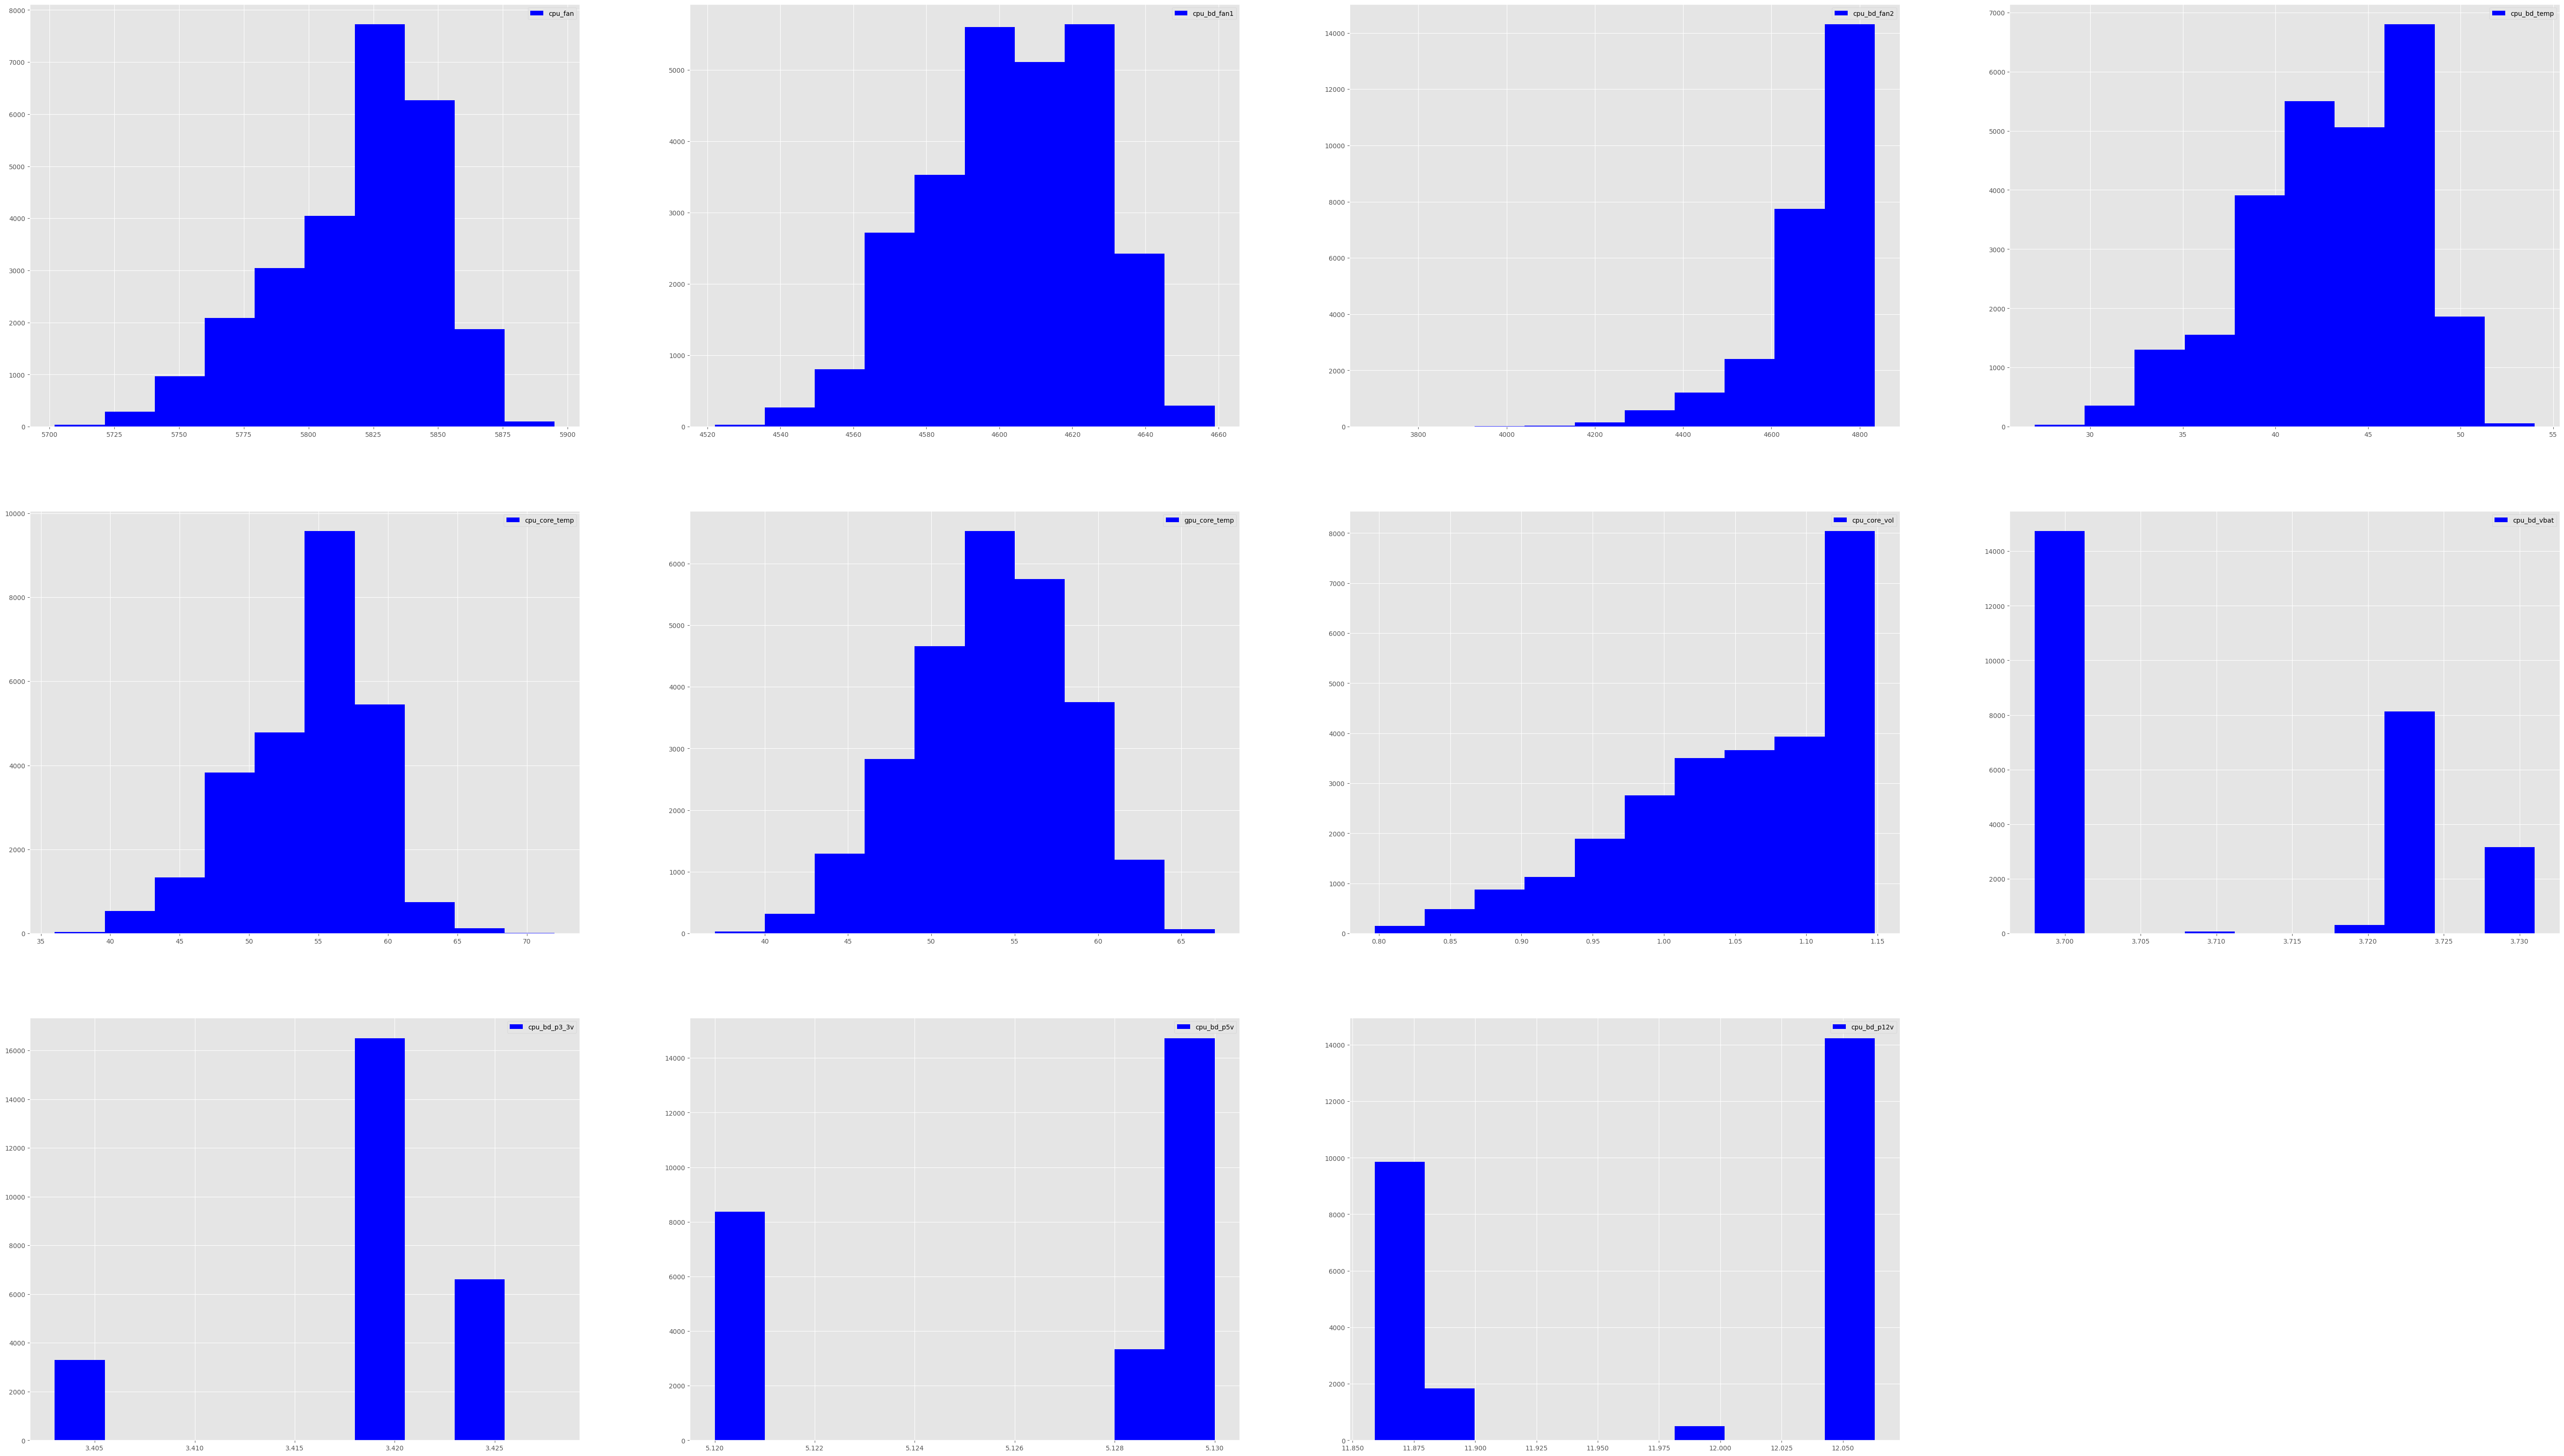

In [26]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(3,4,i+1)
    ax.hist(check_hist[label], color="b", label=column_list2[i] ,bins=10)
    ax.legend()

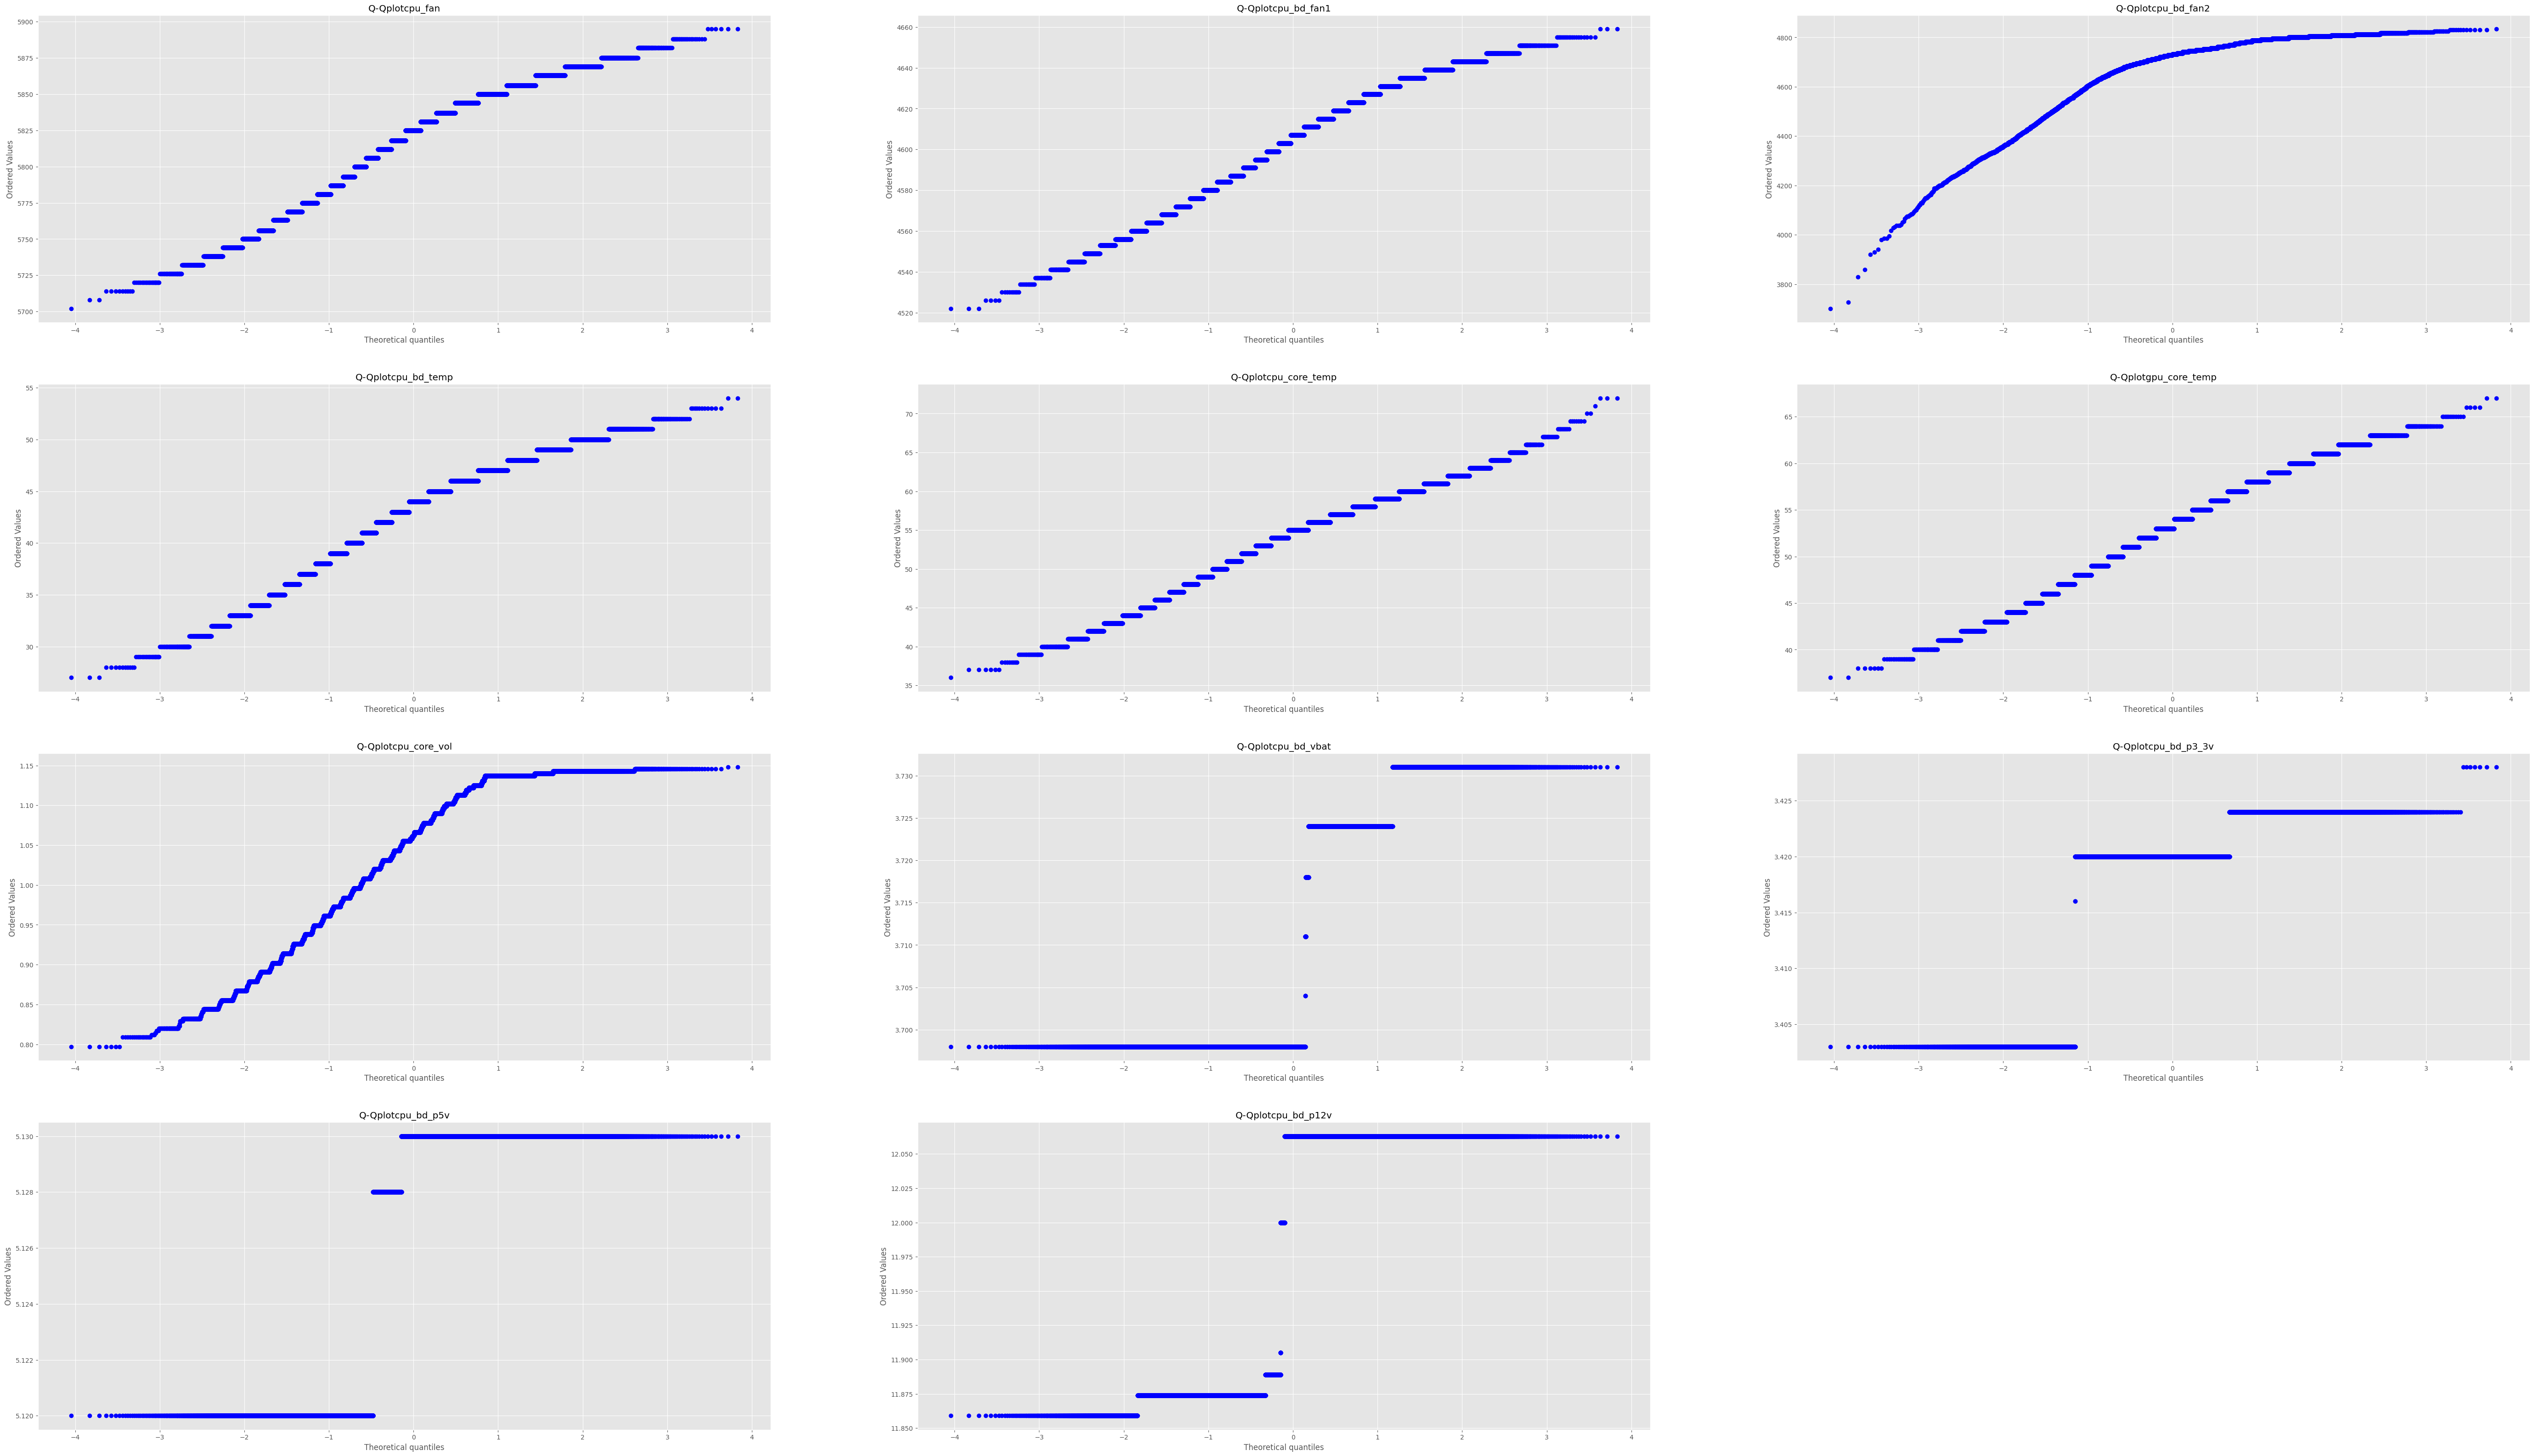

In [27]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(4,3,i+1)
    stats.probplot(check_hist[label], dist="norm", plot=plt)
    ax.set_title("Q-Qplot" + str(column_list2[i]))

特定の期間における processor_unit_units_status_cpu_board_cpu_bd_fan2 の値を時間軸に沿って散布図としてプロット

C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1051845436.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


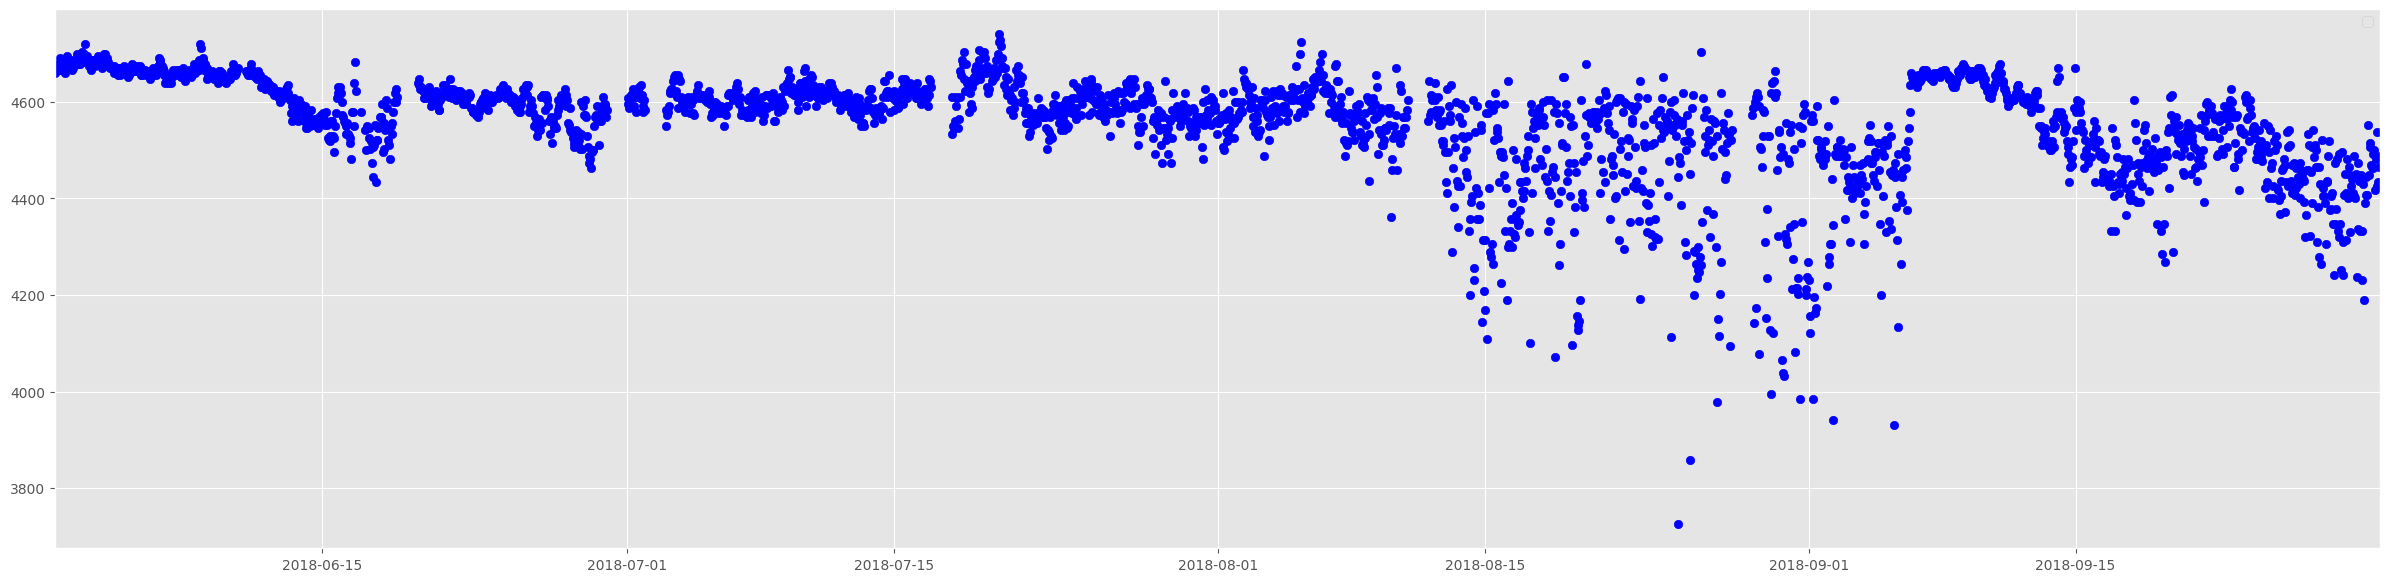

In [28]:
#期間初め
start_day=pd.to_datetime("2018/06/01 00:00:00", format='%Y/%m/%d %H:%M:%S')
#期間終わり
end_day=pd.to_datetime("2018/10/1 00:00:00", format='%Y/%m/%d %H:%M:%S')
test_select_df = check_hist[(check_hist["measurement_date"]>=start_day)&(check_hist["measurement_date"]<end_day)]

time = pd.to_datetime(test_select_df["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(30,7))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(time,test_select_df["processor_unit_units_status_cpu_board_cpu_bd_fan2"], color='blue')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

ここからone class SVMの実装を行う

まずはデータセットの準備から

In [29]:
Select_id_data_set=data_ADP555[data_ADP555["id"]=="9748019T-325"]
colums_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

ここで使用されるカラムは

カラム名	説明

processor_unit_units_status_cpu_board_cpu_fan	CPUボードのCPUファンのステータス

processor_unit_units_status_cpu_board_cpu_bd_fan1	CPUボードのファン1のステータス

processor_unit_units_status_cpu_board_cpu_bd_fan2	CPUボードのファン2のステータス

processor_unit_units_status_cpu_board_cpu_bd_temp	CPUボードの温度

processor_unit_units_status_cpu_board_cpu_core_temp	CPUコアの温度

processor_unit_units_status_cpu_board_gpu_core_temp	GPUコアの温度

processor_unit_units_status_cpu_board_cpu_core_vol	CPUコアの電圧

processor_unit_units_status_cpu_board_cpu_bd_vbat	CPUボードのバッテリ電圧

processor_unit_units_status_cpu_board_cpu_bd_p3_3v	CPUボードの3.3V電源

processor_unit_units_status_cpu_board_cpu_bd_p5v	CPUボードの5V電源

processor_unit_units_status_cpu_board_cpu_bd_p12v	CPUボードの12V電源

In [30]:
Select_id_data_set

,id,equipment_label_no,f_shipno,measurement_date,processor_unit_units_hardware_info_serial_number_cpu_bd,monitor1_units_unit,monitor2_units_unit,measurement_ymd,measurement_ymd_h,measurement_ymd_hms,...,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_storage_device_wearout_ind,processor_unit_units_status_boot_device_wearout_ind,order,tag
1038152,9748019T-325,325,9748019T,2015-12-22 06:15:00,O14K5041,MU-190,MU-190,2015-12-22,06,2015-12-22 06:00:00,...,3.711,3.420,5.120,11.874,4599.0,4724.0,NaN,NaN,1.0,9748019T-325-2015-12-22
1038154,9748019T-325,325,9748019T,2015-12-22 07:00:02,O14K5041,MU-190,MU-190,2015-12-22,07,2015-12-22 07:00:00,...,3.704,3.420,5.120,11.859,4611.0,4736.0,NaN,NaN,1.0,9748019T-325-2015-12-22
1038155,9748019T-325,325,9748019T,2015-12-22 08:00:03,O14K5041,MU-190,MU-190,2015-12-22,08,2015-12-22 08:00:00,...,3.704,3.424,5.120,11.874,4599.0,4753.0,NaN,NaN,1.0,9748019T-325-2015-12-22
1038156,9748019T-325,325,9748019T,2015-12-22 09:00:03,O14K5041,MU-190,MU-190,2015-12-22,09,2015-12-22 09:00:00,...,3.704,3.420,5.120,11.874,4599.0,4749.0,NaN,NaN,1.0,9748019T-325-2015-12-22
1038157,9748019T-325,325,9748019T,2015-12-22 10:00:03,O14K5041,MU-190,MU-190,2015-12-22,10,2015-12-22 10:00:00,...,3.711,3.420,5.128,11.874,4587.0,4749.0,NaN,NaN,1.0,9748019T-325-2015-12-22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064736,9748019T-325,325,9748019T,2019-02-04 19:00:02,O14K5041,NaN,NaN,2019-02-04,19,2019-02-04 19:00:00,...,3.698,3.420,5.130,12.063,4572.0,4481.0,NaN,NaN,1.0,9748019T-325-2019-02-04
1064737,9748019T-325,325,9748019T,2019-02-04 20:00:02,O14K5041,NaN,NaN,2019-02-04,20,2019-02-04 20:00:00,...,3.698,3.403,5.130,12.063,4572.0,4599.0,NaN,NaN,1.0,9748019T-325-2019-02-04
1064738,9748019T-325,325,9748019T,2019-02-04 21:00:02,O14K5041,NaN,NaN,2019-02-04,21,2019-02-04 21:00:00,...,3.698,3.420,5.130,12.063,4560.0,4568.0,NaN,NaN,1.0,9748019T-325-2019-02-04
1064739,9748019T-325,325,9748019T,2019-02-04 22:00:02,O14K5041,NaN,NaN,2019-02-04,22,2019-02-04 22:00:00,...,3.698,3.420,5.130,12.063,4572.0,4522.0,NaN,NaN,1.0,9748019T-325-2019-02-04


実験条件の整理：

1か月のデータを直近２年間のデータを使用して実験を行う

In [31]:
# measurement_dateをdatetime型に変換
Select_id_data_set["measurement_date"] = pd.to_datetime(Select_id_data_set["measurement_date"], format='%Y/%m/%d %H:%M:%S')

# measurement_dateの最小値と最大値を取得
min_date = Select_id_data_set["measurement_date"].min()
max_date = Select_id_data_set["measurement_date"].max()

# 月の差を計算
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1

# 結果の出力
print("Measurement Date の範囲:", min_date, "から", max_date)
print("データの月数:", total_months, "ヶ月分")


Measurement Date の範囲: 2015-12-22 06:15:00 から 2019-02-04 23:00:02
データの月数: 39 ヶ月分


C:\Users\小山佳祐\AppData\Local\Temp\ipykernel_7640\1895274812.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Select_id_data_set["measurement_date"] = pd.to_datetime(Select_id_data_set["measurement_date"], format='%Y/%m/%d %H:%M:%S')


上記を見るとデータは３９か月分である。よって２年間のデータをトレーニングし、テストをするには１５回分出来る。

In [32]:
print(39-24-15)

0


モデルの準備

In [33]:
%%time
#現在時刻の取得
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

#pandasの表示オプションの設定と警告の無視
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')     

import math
import os

# 保存先
ans_data_set_no_cor=pd.DataFrame()

# パラメータ
NU=0.02
gam=1.0

# 準備
#特定のカラムの抜き出しと日時の抜き出し
data_OCSVM = Select_id_data_set[colums_list+["measurement_date"]]
data_OCSVM=data_OCSVM.dropna(how='any')
data_OCSVM=data_OCSVM.reset_index(drop = True)
data_OCSVM["measurement_date"]=pd.to_datetime(data_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

#初期データの抜き出し
Select_data=data_OCSVM["measurement_date"][0]

#終了データの日時。トレーニングデータは２年分である。
#なお、初期データから終了データー１月までを学習データとしendデータをテストする。
data_year=Select_data.year+2
data_month=Select_data.month
end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"


# for文の回数、モデルの学習と実行を15回繰り返す
data_len=len(data_OCSVM)
for_times=15
print("for文の回数：",for_times)
#------------------------------------------------------------------------
# スタートの傾き・モデル作成
print("-------------------------モデル1-----------------------------")

#一回目のトレーニングデータの抜き出し
model_data=data_OCSVM[data_OCSVM["measurement_date"]<end_data]
print("OCSVMトレーニング期間終了",end_data)
model_data=model_data[colums_list]
model_data=model_data.values

#データの標準化
mm_ADP555 = preprocessing.MinMaxScaler()
train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))

#０での処理のエラーを防ぐ
train_OCSVM += 0.0001

#モデルの作成
model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")

#モデルの学習
model_ADP555.fit(train_OCSVM)

#トレーニングデータに対する予測を返す
pre_train=model_ADP555.predict(train_OCSVM)


#作成したモデルを調査する
print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
# print("傾き",model_ADP555.coef_)
# print("切片",model_ADP555.intercept_)
print("データ数",len(train_OCSVM))
print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")

#------------------------------------------------------------------------

#テストデータに関して値を算出する
for i in range(for_times):

    #テストデータは一か月である
    start_data=end_data
    if data_month==12:
        data_month=1
        data_year+=1
    else:
        data_month+=1
    end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    print("OCSVMテスト期間開始",start_data)
    print("OCSVMテスト期間終了",end_data)

    #テストデータの抜き出しを行う
    test_data=data_OCSVM[(data_OCSVM["measurement_date"]>=start_data)&(data_OCSVM["measurement_date"]<end_data)]
    data_set=test_data[["measurement_date"]+colums_list].reset_index(drop = True)
    test_data=test_data[colums_list].reset_index(drop = True)
    test_data=test_data.values
    
#------------------------------------------------------------------------
  
    #データの標準化
    test_OCSVM = mm_ADP555.transform((test_data).reshape(len(test_data), -1))
    test_OCSVM += 0.0001

    print("テストデータ数：",len(test_OCSVM))
    MinMax_data=pd.DataFrame(test_OCSVM)

    #モデルに対してテストデータを学習させ、テストデータの異常スコアを計算する。スコアが高いほど異常とする
    score_set_OCSVM=model_ADP555.decision_function(test_OCSVM)*(-1)
    score_set_OCSVM=pd.DataFrame(score_set_OCSVM)
    
    
    #トレーニングデータと異常値スコアの出力
    dt_anormaly = pd.DataFrame({"measurement_date": data_set["measurement_date"],
                                "processor_unit_units_status_cpu_board_cpu_fan": data_set["processor_unit_units_status_cpu_board_cpu_fan"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan1": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan1"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan2": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan2"],
                                "processor_unit_units_status_cpu_board_cpu_bd_temp": data_set["processor_unit_units_status_cpu_board_cpu_bd_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_temp": data_set["processor_unit_units_status_cpu_board_cpu_core_temp"],
                                "processor_unit_units_status_cpu_board_gpu_core_temp": data_set["processor_unit_units_status_cpu_board_gpu_core_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_vol": data_set["processor_unit_units_status_cpu_board_cpu_core_vol"],
                                "processor_unit_units_status_cpu_board_cpu_bd_vbat": data_set["processor_unit_units_status_cpu_board_cpu_bd_vbat"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p3_3v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p3_3v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p5v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p5v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p12v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p12v"],
#                                 "coef_cpu_fan": coef_list[0],
#                                 "coef_cpu_bd_fan1": coef_list[1],
#                                 "coef_cpu_bd_fan2": coef_list[2],
#                                 "coef_cpu_bd_temp": coef_list[3],
#                                 "coef_cpu_core_temp": coef_list[4],
#                                 "coef_gpu_core_temp": coef_list[5],
#                                 "coef_cpu_core_vol": coef_list[6],
#                                 "coef_cpu_bd_vbat": coef_list[7],
#                                 "coef_cpu_bd_p3_3v": coef_list[8],
#                                 "coef_cpu_bd_p5v": coef_list[9],
#                                 "coef_cpu_bd_p12v": coef_list[10],
#                                 "intercept": intercept_list[0],
                               
#                                 "Model_cpu_fan": Model_data[0],
#                                 "Model_cpu_bd_fan1": Model_data[1],
#                                 "Model_cpu_bd_fan2": Model_data[2],
#                                 "Model_cpu_bd_temp": Model_data[3],
#                                 "Model_cpu_core_temp": Model_data[4],
#                                 "Model_gpu_core_temp": Model_data[5],
#                                 "Model_cpu_core_vol": Model_data[6],
#                                 "Model_cpu_bd_vbat": Model_data[7],
#                                 "Model_cpu_bd_p3_3v": Model_data[8],
#                                 "Model_cpu_bd_p5v": Model_data[9],
#                                 "Model_cpu_bd_p12v": Model_data[10],
                                "score_abnormal_OCSVM":score_set_OCSVM[0],
                                
                                }).reset_index(drop = True)

     #ここに異常値結果が入力されていく   
     # 学習データを用いてテストデータの各時刻に対して異常スコアが計算されていくイメージ                        
    ans_data_set_no_cor=pd.concat([ans_data_set_no_cor,dt_anormaly], ignore_index=True)


#------------------------------------------------------------------------
    #次の学習データの設定


    #data_yearが予測したい年なのでトレーニングデータはそこから２年マイナス
    train_start_data=str(data_year-2)+"/"+str(data_month)+"/01 00:00:00"
    train_end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    
    print("-------------------------モデル"+str(i+2)+"-----------------------------")
    print("OCSVMトレーニング期間開始",train_start_data)
    print("OCSVMトレーニング期間終了",train_end_data)


    #学習データの取得
    model_data=data_OCSVM[(data_OCSVM["measurement_date"]>=train_start_data)&(data_OCSVM["measurement_date"]<train_end_data)]
    
    model_data=model_data[colums_list]
    cor=model_data.corr()
    cor=cor.values
    model_data=model_data.values
    
    #データの標準化
    mm_ADP555 = preprocessing.MinMaxScaler()
    train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))
    train_OCSVM += 0.0001

    #モデルの作成及び学習
    model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")
    model_ADP555.fit(train_OCSVM)
    pre_train=model_ADP555.predict(train_OCSVM)

    #結果の出力
    print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
#     print("傾き",model_ADP555.coef_)
#     print("切片",model_ADP555.intercept_)
    print("データ数",len(train_OCSVM))
    print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")
#------------------------------------------------------------------------

2024/08/08 15:22
for文の回数： 15
-------------------------モデル1-----------------------------
OCSVMトレーニング期間終了 2017/12/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 16602
サポートベクター数 341 

OCSVMテスト期間開始 2017/12/01 00:00:00
OCSVMテスト期間終了 2018/1/01 00:00:00
テストデータ数： 740
-------------------------モデル2-----------------------------
OCSVMトレーニング期間開始 2016/1/01 00:00:00
OCSVMトレーニング期間終了 2018/1/01 00:00:00
設定異常割合：2.00% 		学習異常割合：2.00%
データ数 17133
サポートベクター数 358 

OCSVMテスト期間開始 2018/1/01 00:00:00
OCSVMテスト期間終了 2018/2/01 00:00:00
テストデータ数： 744
-------------------------モデル3-----------------------------
OCSVMトレーニング期間開始 2016/2/01 00:00:00
OCSVMトレーニング期間終了 2018/2/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 17133
サポートベクター数 356 

OCSVMテスト期間開始 2018/2/01 00:00:00
OCSVMテスト期間終了 2018/3/01 00:00:00
テストデータ数： 670
-------------------------モデル4-----------------------------
OCSVMトレーニング期間開始 2016/3/01 00:00:00
OCSVMトレーニング期間終了 2018/3/01 00:00:00
設定異常割合：2.00% 		学習異常割合：2.03%
データ数 17107
サポートベクター数 357 

OCSVMテスト期間開始 2018/3/01 00:00:00
OCSVM

異常結果の出力

In [35]:
for i in range(len(ans_data_set_no_cor)):
    print(ans_data_set_no_cor["score_abnormal_OCSVM"][i]);
    

-5.3913054720662075
-8.165422959226504
-14.886890288805532
-10.22137459801101
-14.858553894121997
-7.293395897898435
-12.934810652752716
-9.602729501921672
-10.328669687963483
-6.5429142698477705
-2.09003795431758
1.129453728406169
0.21509168049344396
8.144238839866908
-1.481821369340409
2.7233366365232783
1.6436090236769445
-1.1404269624661723
2.8171039420584734
-7.6581310150091895
-1.5598912007950645
-6.343054970227598
-4.85433454884658
-5.748283514182091
-7.124546696799001
-9.77498931071473
-10.507250750658585
-8.32410030193681
-8.618883496569325
-13.224491937263892
-9.048903683282305
-4.190671946924624
1.432621167647575
-5.364746880765992
-3.9687163334301516
-8.455345077705658
-6.18103287585096
-3.288744626919552
-2.903772221576716
-2.353442056251623
-2.764233365048071
-2.9677739733581063
-2.6148200758205036
-1.5886687180000365
-9.421859760400523
-7.1226246100884225
-12.955391790571213
-10.883126144207324
-7.903781232752422
-12.468720376226159
-13.813532561431145
-6.72108408980462


次に結果を可視化する。ここでは時系列ごとに異常度と、もとの特徴量の値を可視化する。

2024/08/04 21:12
データ数： 9823
1-class SVM異常検知個数： 1128
1-class SVM異常検知割合：11.48%
CPU times: total: 78.1 ms
Wall time: 143 ms


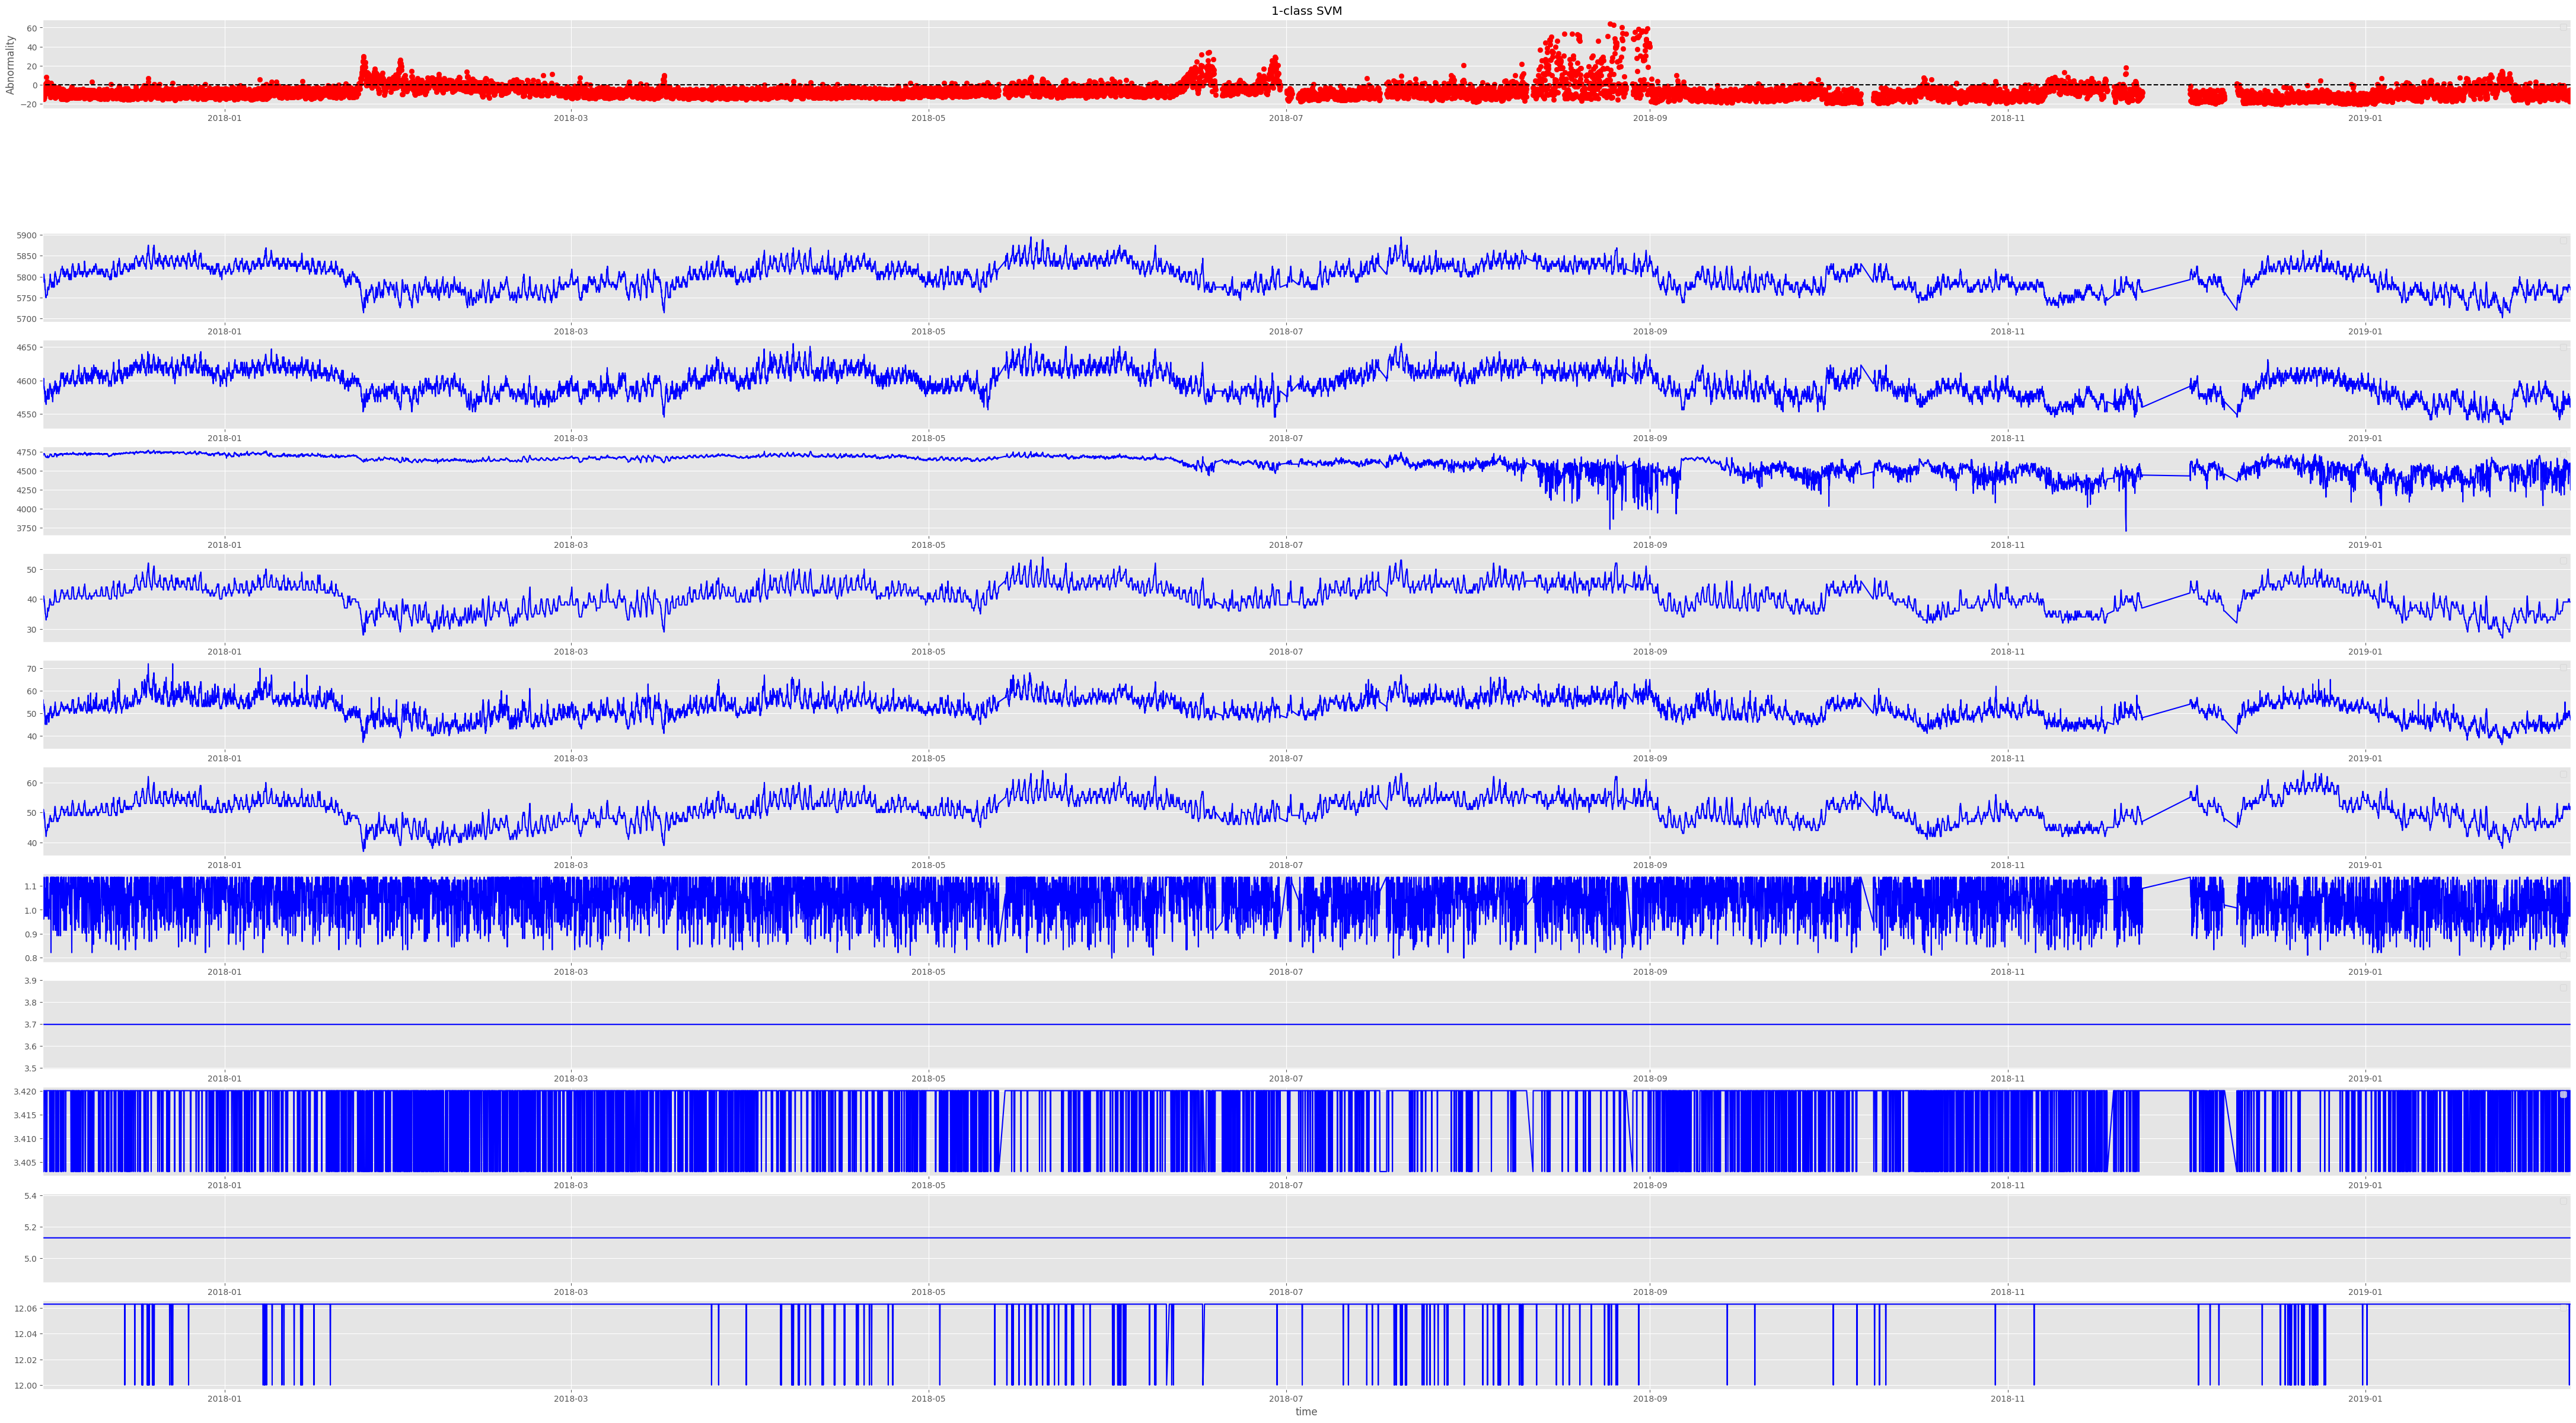

In [40]:
%%time
#現在時刻の取得
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 


time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')

#異常スコアの出力
#図の大きさを指定
fig = plt.figure(figsize=(55,30))

#はじめのサブプロットの作成（異常スコア）
ax1 = fig.add_subplot(13,1,1)
ax1.set_title("1-class SVM")

#score_abnormal_OCSVMが異常スコアとして使用される
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
#異常スコアの閾値ラインの設定
#異常スコアが０は丁度正常領域と異常領域の間にある。したがって０より大きい場合は異常データとみなされる。
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()


# 元データの出力
# 元の特徴量の時系列ごとのデータ
for i, column in enumerate (colums_list):
    ax = fig.add_subplot(13,1,i+3)
    ax.plot(time,ans_data_set_no_cor[column], color='b')
    ax.set_xlabel('time')
    ax.set_xlim(time.min(),time.max())
    ax.legend()

print("データ数：",ans_data_set_no_cor["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知個数：",ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知割合：{:.2%}".format(ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count()/ans_data_set_no_cor["score_abnormal_OCSVM"].count()))


異常データのみの出力

2024/08/08 16:15
CPU times: total: 15.6 ms
Wall time: 284 ms


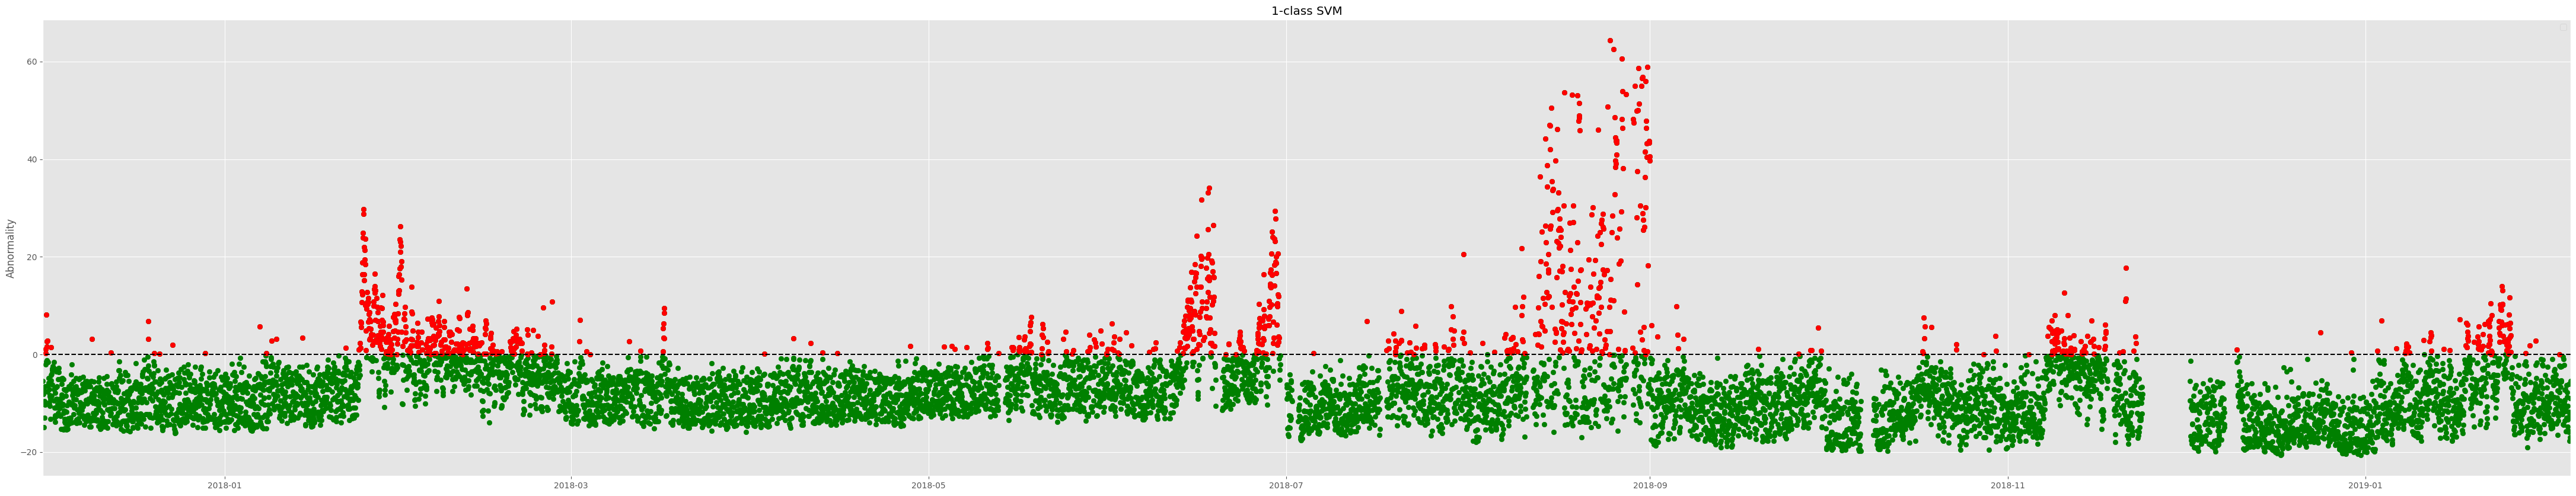

In [38]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')


#異常データのみを抽出する(赤で表現するため)
select_OCSVM=ans_data_set_no_cor[ans_data_set_no_cor["score_abnormal_OCSVM"]>0]


time1 = pd.to_datetime(select_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(55,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("1-class SVM")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='g')
ax1.scatter(time1,select_OCSVM["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

